In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [6]:
bb_data = pd.read_sql_query("SELECT * FROM blackberry", con=conn)
bb_df = pd.DataFrame(bb_data)
bb_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,1999-02-04,2.145833,2.166667,1.895833,1.924479,1.924479,16788600
1,1999-02-05,1.929688,1.947917,1.822917,1.833333,1.833333,3053400
2,1999-02-08,1.854167,1.927083,1.783854,1.812500,1.812500,1548000
3,1999-02-09,1.822917,1.833333,1.656250,1.666667,1.666667,3501600
4,1999-02-10,1.708333,1.708333,1.604167,1.677083,1.677083,1597200


In [ ]:
# Get the data, read csv file into data frame
# df = pd.read_csv("AAPL.csv")
# df.head()

In [7]:
# Check the rows and columns of df
bb_df.shape

(5945, 7)

In [8]:
# Check if there is null values
bb_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [9]:
# Check the data types in df
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5945 non-null   object 
 1   open_price   5945 non-null   float64
 2   high_price   5945 non-null   float64
 3   low_price    5945 non-null   float64
 4   close_price  5945 non-null   float64
 5   adj_close    5945 non-null   float64
 6   volume       5945 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 325.2+ KB


In [10]:
# Change [Date] data type to data time

bb_df['Date'] = pd.to_datetime(bb_df.Date)

In [11]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5945 non-null   datetime64[ns]
 1   open_price   5945 non-null   float64       
 2   high_price   5945 non-null   float64       
 3   low_price    5945 non-null   float64       
 4   close_price  5945 non-null   float64       
 5   adj_close    5945 non-null   float64       
 6   volume       5945 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 325.2 KB


In [12]:
# Delete 'Adj Close' column and check df

bb_df = df.drop('adj_close', axis=1)
bb_df.tail()

,Date,open_price,high_price,low_price,close_price,volume
5940,2022-09-13,5.90,5.99,5.83,5.93,6715400
5941,2022-09-14,5.94,6.05,5.83,5.96,7881800
5942,2022-09-15,5.90,6.10,5.89,6.05,7950900
5943,2022-09-16,5.92,5.92,5.66,5.72,5643200
5944,2022-09-19,5.62,5.77,5.56,5.74,6396900


In [15]:
bb_df.set_index('Date')

,open_price,high_price,low_price,close_price,volume
Date,,,,,
1999-02-04,2.145833,2.166667,1.895833,1.924479,16788600
1999-02-05,1.929688,1.947917,1.822917,1.833333,3053400
1999-02-08,1.854167,1.927083,1.783854,1.812500,1548000
1999-02-09,1.822917,1.833333,1.656250,1.666667,3501600
1999-02-10,1.708333,1.708333,1.604167,1.677083,1597200
...,...,...,...,...,...
2022-09-13,5.900000,5.990000,5.830000,5.930000,6715400
2022-09-14,5.940000,6.050000,5.830000,5.960000,7881800
2022-09-15,5.900000,6.100000,5.890000,6.050000,7950900


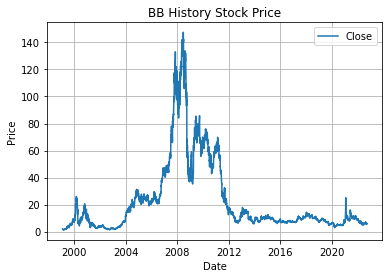

In [16]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(bb_df['Date'], bb_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BB History Stock Price')
plt.grid()
plt.legend()
plt.show()

# Multiple Linear Regression Model

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [18]:
# Split our preprocessed data into our features and target arrays

X = bb_df[['open_price','high_price','low_price','volume']].values
y = bb_df['close_price'].values

In [19]:
# Split the preprocessed data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [20]:
# Check the shape of X_train and X_test

print(X_train.shape)
print(X_test.shape)

(4458, 4)
(1487, 4)


In [21]:
# Build linear reg model

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [25]:
# Check the model score

lr_model.score(X_train, y_train)

0.9997635230910699

In [26]:
# Make stock price prediction

prediction = lr_model.predict(X_test)

print(prediction.shape)
print(prediction)

(1487,)
[ 7.07024107  9.91884785 62.05358664 ...  2.62858694 20.86661344
 22.28151238]


In [27]:
# Compare y_test and our prediction value

pred_df = pd.DataFrame({'Actual Price':y_test, 'Predicted Price':prediction})

pred_df.head(20)

,Actual Price,Predicted Price
0,7.050000,7.070241
1,9.880000,9.918848
2,62.410000,62.053587
3,7.430000,7.441019
4,21.630000,21.906761
5,6.200000,6.175861
6,140.840000,139.526198
7,7.940000,7.900663
8,2.983333,2.742798
9,8.430000,8.473819


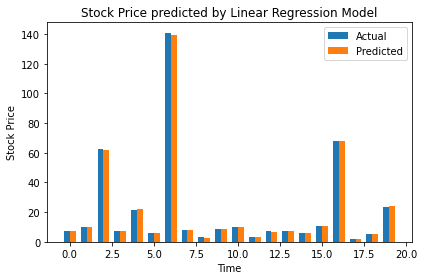

In [61]:
# Plot the actual and predicted price
# from the above data frame, we can see the difference between 'actual price' and 'predicted price' is tiny
# if using line graph, the two lines will be overlapped to each other.
# so we choose to use bar graph to show the difference

fig_df = pred_df.loc[pred_df.index<20]

x = np.arange(len(fig_df['Actual Price']))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fig_df['Actual Price'], width, label='Actual')
rects2 = ax.bar(x + width/2, fig_df['Predicted Price'], width, label='Predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price predicted by Linear Regression Model')
ax.legend()
fig.tight_layout()
plt.show()

In [39]:
print(lr_model.coef_)
print(lr_model.intercept_)

[-6.04633013e-01  8.49151347e-01  7.54209287e-01 -1.14024046e-09]
-0.0010973939316194503


In [41]:
# Calculate the MSE for our model
# The mean squared error (MSE) tells you how close a regression line is to a set of points
# return a non-negative floating point value (the best value is 0.0)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, prediction)

0.22175367673634705

# Using more popular LSTM model to predict stock price

In [42]:
# Choose "Closed" price column as our input variable
close_df= bb_df['close_price']

data_len = round(len(close_df) * 0.8)

close_df_train = close_df.loc[close_df.index < data_len]
close_df_test = close_df.loc[close_df.index >= data_len]

print(close_df_train.head())
print()
print(close_df_test.head())

0    1.924479
1    1.833333
2    1.812500
3    1.666667
4    1.677083
Name: close_price, dtype: float64

4756    11.35
4757    11.17
4758    12.02
4759    13.53
4760    13.37
Name: close_price, dtype: float64


In [43]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_df_train.values.reshape(-1,1))
scaled_data.shape

(4756, 1)

In [44]:
# Use the previous 30 days 'close' price to predict the 31st day's price
previous_days = 30

In [45]:
# Splite data into X_train and y_train
X_train = []
y_train = []

for i in range(previous_days, len(scaled_data)):
    X_train.append(scaled_data[i-previous_days:i, 0])
    y_train.append(scaled_data[i, 0])

In [46]:
# Convert the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4726, 30)
(4726,)


In [47]:
# Reshape the X_train since LSTM needs 3-dimensional inputs
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4726, 30, 1)

In [48]:
# Build the LSTM model
model = Sequential()
# Add LSTM layer
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 50))
# prediction output layer
model.add(Dense(units=1))

In [49]:
# compile and train the data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size =32, epochs=20)

Epoch 1/20
148/148 [==============================] - 13s 25ms/step - loss: 0.0023
Epoch 2/20
148/148 [==============================] - 3s 23ms/step - loss: 7.6091e-04
Epoch 3/20
148/148 [==============================] - 3s 22ms/step - loss: 5.3377e-04
Epoch 4/20
148/148 [==============================] - 4s 24ms/step - loss: 5.3464e-04
Epoch 5/20
148/148 [==============================] - 3s 23ms/step - loss: 3.8350e-04
Epoch 6/20
148/148 [==============================] - 4s 24ms/step - loss: 3.4908e-04
Epoch 7/20
148/148 [==============================] - 3s 23ms/step - loss: 2.9864e-04
Epoch 8/20
148/148 [==============================] - 4s 28ms/step - loss: 2.9941e-04
Epoch 9/20
148/148 [==============================] - 4s 24ms/step - loss: 2.8930e-04
Epoch 10/20
148/148 [==============================] - 3s 23ms/step - loss: 2.4867e-04
Epoch 11/20
148/148 [==============================] - 4s 24ms/step - loss: 2.3711e-04
Epoch 12/20
148/148 [==============================] - 

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [51]:
#### Test model ####

# Scale the testing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(close_df_test.values.reshape(-1,1))
scaled_test_data.shape

(1189, 1)

In [52]:
# Create X_test and y_test
X_test = []
y_test = []

for i in range(previous_days, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-previous_days:i, 0])
    y_test.append(scaled_test_data[i, 0])

In [53]:
# Convert the X_test and y_test to numpy arrays
X_test = np.array(X_test)
print(X_test.shape)

(1159, 30)


In [54]:
# reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(1159, 30, 1)


In [55]:
# Predict the data

prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)

37/37 [==============================] - 2s 9ms/step


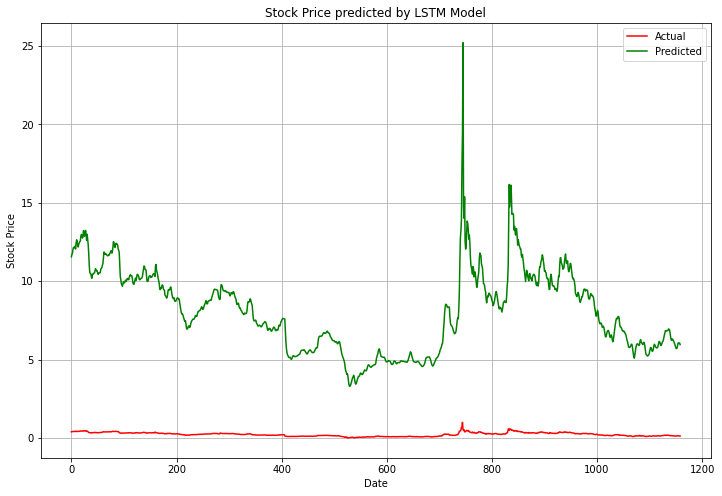

In [60]:
# plot test predictions

plt.figure(figsize=(12, 8))
plt.plot(y_test, color='red', label='Actual')
plt.plot(prediction, color='green', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.title("Stock Price predicted by LSTM Model")
plt.grid()
plt.legend()
plt.show()